# Machine Learning in Python using Clemson High Performance Computing

## 1. Introduction

### 1.1 Welcome and Overview

#### Overview

Machine learning is a powerful tool for making sense of large datasets. In this workshop, we will introduce the basics of machine learning using Python. We will emphasize the use of Clemson's Palmetto Cluster for running machine learning algorithms on large datasets. We will cover the following topics:
* What is machine learning?
* What are some of the python tools that facilitate machine learning?
* What are the different types of machine learning?
* What are some of the common machine learning algorithms?
* How do we evaluate the performance of machine learning algorithms?
* How do we explore and clean data?
* How do we prepare data for machine learning?
* How do we make use of Clemson's Palmetto Cluster to efficiently run our machine learning code?
* How can we run code that is too complex, or use data that is too large, for a Jupyter notebook?
* What sorts of Palmetto resources should we request to allocate for our machine learning jobs?

##### What is machine learning?

People use the term "machine learning" in a variety of ways. Some people use it more or less synonymously with "artificial intelligence." And these days, AI does indeed usually work under the paradigm of machine learning. But "machine learning" refers to the use of algorithms to learn from data. The contrast here is with traditional programming, where a programmer writes code that tells the computer exactly what to do. In machine learning, the programmer writes code that tells the computer how to learn from data to make decisions.

![ML vs traditional](img/ml.png)

## 1.2 Examples showcase

Python libraries like Scikit-Learn and PyTorch are widely used for machine learning tasks. Before diving in to the rest of the workshop, in this section we will showcase what is possible when such libraries are combined with the powerful computational resources available to you through the Palmetto 2 Cluster.

## [Forest Covertypes Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html#sklearn.datasets.fetch_covtype)

First, we will use the Forest Covertypes dataset, which is a dataset that contains information about the forest cover type in the Roosevelt National Forest of northern Colorado. The dataset contains 581,012 samples and 54 features. The data contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types). The goal is to predict the forest cover type based on the cartographic features provided. 

In [ ]:
from sklearn.datasets import fetch_covtype
cov_type = fetch_covtype()

As we should always do with any dataset we're working with, we should poke around it a bit to see what it looks like. It's always good to know what is the datatype of the object we're working with.

In [2]:
type(cov_type)

sklearn.utils._bunch.Bunch

In this case we've got a scikit-learn "Bunch" object. A quick google search shows us this page of documentation: [sklearn.utils.Bunch Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html), where we learn that a Bunch is a dictionary-like object that exposes keys as attributes. So, let's see what keys are in this Bunch object.

In [3]:
cov_type.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [4]:
print(cov_type.DESCR)

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

=================   ============
Classes                        7
Samples total             581012
Dimensionality                54
Features                     int
=================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional argument 'as_frame' is
se

In [5]:
cov_type.data

array([[2.596e+03, 5.100e+01, 3.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.590e+03, 5.600e+01, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.804e+03, 1.390e+02, 9.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.386e+03, 1.590e+02, 1.700e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.384e+03, 1.700e+02, 1.500e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.383e+03, 1.650e+02, 1.300e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [6]:
cov_type.data.shape

(581012, 54)

In [7]:
cov_type.target

array([5, 5, 2, ..., 3, 3, 3], dtype=int32)

In [8]:
cov_type.target.shape

(581012,)

In [9]:
cov_type.frame

In [10]:
type(cov_type.frame)

NoneType

In [11]:
cov_type.target_names

['Cover_Type']

In [12]:
cov_type.feature_names

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'Wilderness_Area_0',
 'Wilderness_Area_1',
 'Wilderness_Area_2',
 'Wilderness_Area_3',
 'Soil_Type_0',
 'Soil_Type_1',
 'Soil_Type_2',
 'Soil_Type_3',
 'Soil_Type_4',
 'Soil_Type_5',
 'Soil_Type_6',
 'Soil_Type_7',
 'Soil_Type_8',
 'Soil_Type_9',
 'Soil_Type_10',
 'Soil_Type_11',
 'Soil_Type_12',
 'Soil_Type_13',
 'Soil_Type_14',
 'Soil_Type_15',
 'Soil_Type_16',
 'Soil_Type_17',
 'Soil_Type_18',
 'Soil_Type_19',
 'Soil_Type_20',
 'Soil_Type_21',
 'Soil_Type_22',
 'Soil_Type_23',
 'Soil_Type_24',
 'Soil_Type_25',
 'Soil_Type_26',
 'Soil_Type_27',
 'Soil_Type_28',
 'Soil_Type_29',
 'Soil_Type_30',
 'Soil_Type_31',
 'Soil_Type_32',
 'Soil_Type_33',
 'Soil_Type_34',
 'Soil_Type_35',
 'Soil_Type_36',
 'Soil_Type_37',
 'Soil_Type_38',
 'Soil_Type_39']

In [13]:
import pandas as pd

# Create a DataFrame using the feature names and data from cov_type
df_cov_type = pd.DataFrame(data=cov_type.data, columns=cov_type.feature_names)

# Display the first few rows of the DataFrame
print("First few rows of the Forest Covertypes Dataset:")
df_cov_type

First few rows of the Forest Covertypes Dataset:


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396.0,153.0,20.0,85.0,17.0,108.0,240.0,237.0,118.0,837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581008,2391.0,152.0,19.0,67.0,12.0,95.0,240.0,237.0,119.0,845.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581009,2386.0,159.0,17.0,60.0,7.0,90.0,236.0,241.0,130.0,854.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581010,2384.0,170.0,15.0,60.0,5.0,90.0,230.0,245.0,143.0,864.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df_cov_type[[col for col in df_cov_type.columns if 'Soil_Type' in col]].describe()


,Soil_Type_0,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,0.005217,0.012952,0.008301,0.021335,0.002749,0.011316,0.000181,0.000308,0.001974,0.056168,...,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060
std,0.072039,0.113066,0.090731,0.144499,0.052356,0.105775,0.013442,0.017550,0.044387,0.230245,...,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's use the K-nearest neighbors algorithm to try to predict covertype using the information contained in the dataset.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Split the data into features (X) and target (y)
X, y = cov_type.data, cov_type.target

# Print the shape of the data
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=355)

# Print the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Features shape: (581012, 54)
Target shape: (581012,)

X_train shape: (464809, 54)
y_train shape: (464809,)
X_test shape: (116203, 54)
y_test shape: (116203,)


Now it's time to train the model.

In [16]:
# Initialize and train the classifier
kn_classifier = KNeighborsClassifier(n_neighbors=5)
kn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

Now let's see how the model performed.

In [17]:
import time
# Start a timer
start_time = time.time()

# Make predictions on the test set
y_pred = kn_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.2f}")

# Get unique class labels
unique_labels = np.unique(y)
target_names = [f"Class {label}" for label in unique_labels]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# See how long that took
print(f"\nTotal time taken: {time.time() - start_time:.4f} seconds")

Accuracy: 0.97

Classification Report:
              precision    recall  f1-score   support

     Class 1       0.97      0.97      0.97     42502
     Class 2       0.97      0.97      0.97     56531
     Class 3       0.96      0.97      0.96      7132
     Class 4       0.92      0.79      0.85       564
     Class 5       0.93      0.89      0.91      1925
     Class 6       0.94      0.93      0.94      3528
     Class 7       0.97      0.97      0.97      4021

    accuracy                           0.97    116203
   macro avg       0.95      0.93      0.94    116203
weighted avg       0.97      0.97      0.97    116203



Now let's look at a version of the same machine learning approach that makes better use of the resources available to us -- using both parallelization across cores and also using the GPU we've provisioned to speed things up.

First, we'll load the data and prepare it for the KNN algorithm.

In [18]:
import cudf
from cuml import KNeighborsClassifier as cuKNN
from dask.distributed import Client, LocalCluster

# Initialize Dask client for distributed computing
n_workers = 4  # Adjust based on your HPC resources
cluster = LocalCluster(n_workers=n_workers)
client = Client(cluster)

# Convert data to cuDF DataFrames for GPU processing
X = cudf.DataFrame(cov_type.data, columns=cov_type.feature_names)
y = cudf.Series(cov_type.target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=355)

Now we fit the KNN model.

In [19]:
# Initialize and train the classifier
kn_classifier_cuml = cuKNN(n_neighbors=5)
kn_classifier_cuml.fit(X_train, y_train)

KNeighborsClassifier()

Now let's see how this model performed.

In [21]:
# Start a timer
start_time = time.time()

# Make predictions on the test set
y_pred = kn_classifier_cuml.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test.to_cupy().get(), y_pred.to_cupy().get())

# Print results
print(f"Accuracy: {accuracy:.2f}")

# Convert predictions to numpy for classification report
y_test_np = y_test.to_numpy()
y_pred_np = y_pred.to_numpy()

# Get unique class labels
unique_labels = np.unique(y_test_np)
target_names = [f"Class {label}" for label in unique_labels]

print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_np, target_names=target_names))

# Clean up
client.close()
cluster.close()

# See how long that took
print(f"\nTotal time taken: {time.time() - start_time:.4f} seconds")

Accuracy: 0.97

Classification Report:
              precision    recall  f1-score   support

     Class 1       0.97      0.97      0.97     42502
     Class 2       0.97      0.97      0.97     56531
     Class 3       0.96      0.97      0.96      7132
     Class 4       0.92      0.79      0.85       564
     Class 5       0.93      0.89      0.91      1925
     Class 6       0.94      0.93      0.94      3528
     Class 7       0.97      0.97      0.97      4021

    accuracy                           0.97    116203
   macro avg       0.95      0.93      0.94    116203
weighted avg       0.97      0.97      0.97    116203


Total time taken: 2.6645 seconds


Notice how much faster inference is in the second case! And this is just a simple case of getting predictions for 116k samples. Imagine if we needed to get predictions for millions of samples. In that case, the second approach would be much more feasible.

### Hyperoptimization: search for the best version of the model to maximize performance

In the above example, I used a KNN model with a k value of 5. But how do we know that k=5 is the best value? We don't. We need to search for the best value of k. This is an example of hyperoptimization. You can think of hyperoptimization as a search for the best version of the model to maximize performance. 

Hyperoptimization is inherently computationally expensive. It involves training many models with different hyperparameters and evaluating their performance. This is a perfect use case for the Palmetto 2 Cluster. We can use the cluster to train many models in parallel, which will speed up the hyperoptimization process. And if we submit our hyperoptimization job as a batch job, then we don't need to tie up our local machine for hours -- or days! -- while the hyperoptimization process runs.

In [22]:
import cudf
import numpy as np
from cuml.neighbors import KNeighborsClassifier
from cuml.model_selection import train_test_split
from cuml.metrics import accuracy_score

# Convert data to cuDF DataFrames for GPU processing and ensure float32 dtype
X = cudf.DataFrame(cov_type.data, columns=cov_type.feature_names).astype('float32')
y = cudf.Series(cov_type.target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=355)

# Use a smaller subset for hyperparameter tuning
X_tune, _, y_tune, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=355)

# Define the parameter space for KNN
param_dist = {
    'n_neighbors': np.arange(1, 21, dtype=int),
    'p': [1, 2],  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Function to perform k-fold cross-validation with batched prediction
def cross_validate(X, y, model, n_splits=3, batch_size=10000):
    fold_size = len(X) // n_splits
    scores = []
    for i in range(n_splits):
        start = i * fold_size
        end = (i + 1) * fold_size
        X_val = X.iloc[start:end]
        y_val = y.iloc[start:end]
        X_train = cudf.concat([X.iloc[:start], X.iloc[end:]])
        y_train = cudf.concat([y.iloc[:start], y.iloc[end:]])
        
        model.fit(X_train, y_train)
        
        # Batched prediction
        y_pred = cudf.Series()
        for j in range(0, len(X_val), batch_size):
            X_batch = X_val.iloc[j:j+batch_size]
            y_pred = cudf.concat([y_pred, model.predict(X_batch)])
        
        score = accuracy_score(y_val, y_pred)
        scores.append(score)
    return np.mean(scores)

# Perform manual randomized search
n_iter = 10
best_score = 0
best_params = {}

for _ in range(n_iter):
    params = {k: np.random.choice(v) for k, v in param_dist.items()}
    knn = KNeighborsClassifier(metric='minkowski', **params)
    score = cross_validate(X_tune, y_tune, knn)
    
    if score > best_score:
        best_score = score
        best_params = params
    
    print(f"Iteration {_+1}/{n_iter} - Score: {score:.4f} - Params: {params}")

print("Best parameters found:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Train the best model on the full training set
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)

# Make predictions on the test set in batches
batch_size = 10000
y_pred = cudf.Series()
for i in range(0, len(X_test), batch_size):
    X_batch = X_test.iloc[i:i+batch_size]
    y_pred = cudf.concat([y_pred, best_knn.predict(X_batch)])

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest model accuracy: {accuracy:.4f}")

Iteration 1/10 - Score: 0.9031 - Params: {'n_neighbors': 9, 'p': 1}
Iteration 2/10 - Score: 0.8647 - Params: {'n_neighbors': 16, 'p': 2}
Iteration 3/10 - Score: 0.8774 - Params: {'n_neighbors': 12, 'p': 2}
Iteration 4/10 - Score: 0.8712 - Params: {'n_neighbors': 14, 'p': 2}
Iteration 5/10 - Score: 0.8798 - Params: {'n_neighbors': 16, 'p': 1}
Iteration 6/10 - Score: 0.8910 - Params: {'n_neighbors': 12, 'p': 1}
Iteration 7/10 - Score: 0.8910 - Params: {'n_neighbors': 12, 'p': 1}
Iteration 8/10 - Score: 0.8746 - Params: {'n_neighbors': 18, 'p': 1}
Iteration 9/10 - Score: 0.8798 - Params: {'n_neighbors': 16, 'p': 1}
Iteration 10/10 - Score: 0.8632 - Params: {'n_neighbors': 17, 'p': 2}
Best parameters found:
n_neighbors: 9
p: 1

Best model accuracy: 0.9636


In [23]:
# Save the best model
import pickle
with open("best_knn_model.pkl", "wb") as f:
    pickle.dump(best_knn, f)

The above, being in a Jupyter notebook, is fine for something that only takes a few minutes. But if we want to e.g. try hundreds of different settings, or a model that takes longer to fit, we should make a script that we can submit as a SLURM job. We just need to copy our code into a .py file and make a SLURM script.

In [ ]:
# This can be what we put in our .py file:

import cudf
import numpy as np
from cuml.neighbors import KNeighborsClassifier
from cuml.model_selection import train_test_split
from cuml.metrics import accuracy_score
from sklearn.datasets import fetch_covtype
import pickle

# Load the covertype dataset
cov_type = fetch_covtype()

# Convert data to cuDF DataFrames for GPU processing and ensure float32 dtype
X = cudf.DataFrame(cov_type.data, columns=cov_type.feature_names).astype('float32')
y = cudf.Series(cov_type.target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=355)

# Use a smaller subset for hyperparameter tuning
X_tune, _, y_tune, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=355)

# Define the parameter space for KNN
param_dist = {
    'n_neighbors': np.arange(1, 21, dtype=int),
    'p': [1, 2],  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Function to perform k-fold cross-validation with batched prediction
def cross_validate(X, y, model, n_splits=3, batch_size=10000):
    fold_size = len(X) // n_splits
    scores = []
    for i in range(n_splits):
        start = i * fold_size
        end = (i + 1) * fold_size
        X_val = X.iloc[start:end]
        y_val = y.iloc[start:end]
        X_train = cudf.concat([X.iloc[:start], X.iloc[end:]])
        y_train = cudf.concat([y.iloc[:start], y.iloc[end:]])
        
        model.fit(X_train, y_train)
        
        # Batched prediction
        y_pred = cudf.Series()
        for j in range(0, len(X_val), batch_size):
            X_batch = X_val.iloc[j:j+batch_size]
            y_pred = cudf.concat([y_pred, model.predict(X_batch)])
        
        score = accuracy_score(y_val, y_pred)
        scores.append(score)
    return np.mean(scores)

# Perform manual randomized search
n_iter = 10 
best_score = 0
best_params = {}

for _ in range(n_iter):
    params = {k: np.random.choice(v) for k, v in param_dist.items()}
    knn = KNeighborsClassifier(metric='minkowski', **params)
    score = cross_validate(X_tune, y_tune, knn)
    
    if score > best_score:
        best_score = score
        best_params = params
    
    print(f"Iteration {_+1}/{n_iter} - Score: {score:.4f} - Params: {params}")

print("Best parameters found:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Train the best model on the full training set
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)

# Make predictions on the test set in batches
batch_size = 10000
y_pred = cudf.Series()
for i in range(0, len(X_test), batch_size):
    X_batch = X_test.iloc[i:i+batch_size]
    y_pred = cudf.concat([y_pred, best_knn.predict(X_batch)])

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest model accuracy: {accuracy:.4f}")

# Save the best model
with open("best_knn_model.pkl", "wb") as f:
    pickle.dump(best_knn, f)

And our SLURM script (saved in a separate file, e.g. `hyperparam_opt.sh`) can be:

```bash
#!/bin/bash
#SBATCH --job-name=hyperparam_opt
#SBATCH --nodes=1# This can be what we put in our .py file:

import cudf
import numpy as np
from cuml.neighbors import KNeighborsClassifier
from cuml.model_selection import train_test_split
from cuml.metrics import accuracy_score
from sklearn.datasets import fetch_covtype
import pickle

# Load the covertype dataset
cov_type = fetch_covtype()

# Convert data to cuDF DataFrames for GPU processing and ensure float32 dtype
X = cudf.DataFrame(cov_type.data, columns=cov_type.feature_names).astype('float32')
y = cudf.Series(cov_type.target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=355)

# Use a smaller subset for hyperparameter tuning
X_tune, _, y_tune, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=355)

# Define the parameter space for KNN
param_dist = {
    'n_neighbors': np.arange(1, 21, dtype=int),
    'p': [1, 2],  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Function to perform k-fold cross-validation with batched prediction
def cross_validate(X, y, model, n_splits=3, batch_size=10000):
    fold_size = len(X) // n_splits
    scores = []
    for i in range(n_splits):
        start = i * fold_size
        end = (i + 1) * fold_size
        X_val = X.iloc[start:end]
        y_val = y.iloc[start:end]
        X_train = cudf.concat([X.iloc[:start], X.iloc[end:]])
        y_train = cudf.concat([y.iloc[:start], y.iloc[end:]])
        
        model.fit(X_train, y_train)
        
        # Batched prediction
        y_pred = cudf.Series()
        for j in range(0, len(X_val), batch_size):
            X_batch = X_val.iloc[j:j+batch_size]
            y_pred = cudf.concat([y_pred, model.predict(X_batch)])
        
        score = accuracy_score(y_val, y_pred)
        scores.append(score)
    return np.mean(scores)

# Perform manual randomized search
n_iter = 10 
best_score = 0
best_params = {}

for _ in range(n_iter):
    params = {k: np.random.choice(v) for k, v in param_dist.items()}
    knn = KNeighborsClassifier(metric='minkowski', **params)
    score = cross_validate(X_tune, y_tune, knn)
    
    if score > best_score:
        best_score = score
        best_params = params
    
    print(f"Iteration {_+1}/{n_iter} - Score: {score:.4f} - Params: {params}")

print("Best parameters found:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Train the best model on the full training set
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)

# Make predictions on the test set in batches
batch_size = 10000
y_pred = cudf.Series()
for i in range(0, len(X_test), batch_size):
    X_batch = X_test.iloc[i:i+batch_size]
    y_pred = cudf.concat([y_pred, best_knn.predict(X_batch)])

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest model accuracy: {accuracy:.4f}")

# Save the best model
with open("best_knn_model.pkl", "wb") as f:
    pickle.dump(best_knn, f)
#SBATCH --ntasks-per-node=4
#SBATCH --time=16:00:00
#SBATCH --gres=gpu:v100:1
#SBATCH --output=hyperparam_opt_%j.out

# Load the modules we need
module load anaconda3
module load cuda

# Activate the environment we created to work in
source activate MLWorkshop

# Change to the directory where the .py script is
cd /home/[username]/dir/where/the/py/script/is/

# And run the script!
python hyperparameter_optimization.py
```

Then we can submit the job with `sbatch hyperparam_opt.sh`, on the command line.

## 2. Setting up the Environment (15 minutes)

### 2.1 Creating a Conda Environment
Why we use conda for ML environments:
* Simplified package management and dependency resolution
* Easy creation and management of isolated environments
* Cross-platform compatibility (Windows, macOS, Linux)
* Support for multiple programming languages (not just Python)
* Ability to specify and replicate exact environment configurations
* Large repository of pre-built packages optimized for different systems
```bash
# Commands for creating and activating a conda environment
conda create -n hpc_ml -c rapidsai -c conda-forge -c nvidia numpy pandas scikit-learn matplotlib seaborn rapidsai jupyterlab python=3.11 'cuda-version>=12.0,<=12.5'
conda activate hpc_ml
```

### 2.2 Registering as a jupyter kernel
In addition to installing JupyterLab, we need to register our environment as a Jupyter kernel in order for it to show up as an option for us when running a notebook.
```bash
# Register the env as a kernel
python -m ipykernel install --user --name hpc_ml --display-name "HPC_ML"
```

## 3 Introduction to Python for Machine Learning

Python has become the de facto language for machine learning due to its simplicity, readability, and extensive ecosystem of libraries. Its flexibility allows for rapid prototyping and development, while its powerful libraries like NumPy, Pandas, and Scikit-learn provide efficient tools for data manipulation and model building.

### 3.1 Essential Python Concepts Review
 
For a broad introduction to Python, check out the [Python Programming Guide](https://www.python.org/about/gettingstarted/). Here are some key features of Python that are particularly useful for machine learning:

* **List Comprehensions**: A concise way to create lists in Python.
* **Lambda Functions**: Anonymous functions that can be defined in a single line.
* **Error Handling**: Using `try`, `except`, and `finally` blocks to handle exceptions.
* **Generators**: Functions that return an iterator, allowing for lazy evaluation (meaning they don't store all values in memory at once).
* **Dynamic Typing**: Variables in Python are dynamically typed, meaning you don't need to specify the type of a variable when you declare it.
* **Runtime Compilation**: Python code is compiled to bytecode, which is then interpreted by the Python interpreter. This allows for dynamic execution of code.

In [24]:
# Code snippets demonstrating key Python concepts
# List comprehension example
squares = [x**2 for x in range(10)]
squares

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [25]:
# Lambda function example
multiply = lambda x, y: x * y
multiply(5, 10)

50

In [27]:
# Error handling example
try:
    result = 10 / 0
except ZeroDivisionError:
    print("Cannot divide by zero")
    
print("This line still runs")

Cannot divide by zero
This line still runs


In [28]:
# Generators example
def fibonacci(n):
    a, b = 0, 1
    for _ in range(n):
        yield a
        a, b = b, a + b

fib = fibonacci(int(1e18)) # Large number to demonstrate generator memory efficiency, the first 1e18 (i.e. 1 quintillion) Fibonacci numbers

In [50]:
# Print the next Fibonacci number
next(fib)

10946

In [51]:
# How much memory does the fib object consume?
import sys
sys.getsizeof(fib)

232

If we were to run `list(fib)`, we would get a list of the first quintillion Fibonacci numbers. But we don't want to do that, because it would take up all the memory on our machine!

### 3.2 Introduction to NumPy

NumPy is a powerful library for numerical computing in Python. It provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays. NumPy is the foundation for many other libraries in the Python data science ecosystem, such as Pandas, Scikit-learn, PyTorch, and TensorFlow. The reason NumPy is so fast is that it is implemented in C, which is a much faster language than Python.

In [52]:
# Basic NumPy operations and array manipulations
import numpy as np

# Create an array
arr = np.array([1, 2, 3, 4, 5])

# Array operations
print("Array operations:")
print("Array:")
print(arr)
print("Array x 2:")
print(arr * 2)
print("Array summed:")
print(np.sum(arr))

# Broadcasting example
matrix = np.array([[1, 2, 3, 4 , 5], [6, 7, 8, 9, 10]])
print("\nBroadcasting example:")
print("Matrix:")
print(matrix)
print("Array:")
print(arr)
print("Matrix + Array:")
print(matrix + arr)

Array operations:
Array:
[1 2 3 4 5]
Array x 2:
[ 2  4  6  8 10]
Array summed:
15

Broadcasting example:
Matrix:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]]
Array:
[1 2 3 4 5]
Matrix + Array:
[[ 2  4  6  8 10]
 [ 7  9 11 13 15]]


### 3.3 Intro to Pandas

Pandas is a powerful data manipulation library for Python. It is built on top of NumPy and provides data structures and functions for efficiently manipulating large datasets. Pandas is widely used in data science and machine learning for data cleaning, exploration, and preparation.

Pandas isn't the best choice for truly massive datasets, since it loads the entire dataset into memory. But even libraries that are better suited for massive datasets, like Dask, tend to conform to the Pandas API, so learning Pandas is a good foundation for working with other libraries.

Pandas is great for organizing and exploring data. We'll spend more time on data exploration in Day 2, but let's take a quick look at how to use Pandas dataframes to organize data. We'll use the California Housing dataset, which is a dataset containing information about housing prices. The dataset contains 20,640 samples and 9 features. The goal is to predict the house value, given a set of features about the property and its district.

In [53]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing

# Load the California housing dataset
california = fetch_california_housing()

# Create a DataFrame
df = pd.DataFrame(california.data, columns=california.feature_names)
# The above created a dataframe with the features, but it doesn't have the target variable. It's easy to add new columns to a Pandas DataFrame:
df['Price'] = california.target

# Display the first few rows of the DataFrame
print("First few rows of the California Housing Dataset:")
print(df.head())

First few rows of the California Housing Dataset:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Price  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  


Pandas includes some methods for quickly summarizing the data in a dataframe.

In [54]:
# Basic data exploration
print("DataFrame Info:")
df.info()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Price       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [55]:
print("Basic Statistics:")
print(df.describe())

Basic Statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude         Price  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.6

Pandas also makes it easy to filter data.

In [56]:
# Filtering data
print("Houses with more than 4 rooms on average:")
print(df[df['AveRooms'] > 4].head())

Houses with more than 4 rooms on average:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Price  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  


In [57]:
print("\nHouses with more than 4 rooms on average and a price above the median:")
print(df[(df['AveRooms'] > 4) & (df['Price'] > df['Price'].median())].head())


Houses with more than 4 rooms on average and a price above the median:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Price  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  


We can also sort the data easily, and add new columns.

In [58]:
# Sorting data
print("\nTop 5 most expensive areas:")
print(df.sort_values('Price', ascending=False).head())


Top 5 most expensive areas:
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
6736  15.0001      47.0  8.592308   1.061538       749.0  2.880769     34.13   
6716   4.7298      30.0  5.941935   1.118280      1143.0  2.458065     34.13   
6732   9.7912      44.0  7.036290   0.955645       693.0  2.794355     34.13   
6733   7.8347      45.0  7.251834   1.014670      1231.0  3.009780     34.12   
9354  10.6272      36.0  8.394191   1.004149       653.0  2.709544     37.94   

      Longitude    Price  
6736    -118.10  5.00001  
6716    -118.15  5.00001  
6732    -118.10  5.00001  
6733    -118.09  5.00001  
9354    -122.56  5.00001  


In [59]:
# Adding a new column
df['PriceCategory'] = pd.cut(df['Price'], bins=[0, 1.25, 2.5, 3.75, np.inf], labels=['Low', 'Medium', 'High', 'Very High'])
print("\nDataFrame with new PriceCategory column:")
print(df.head())


DataFrame with new PriceCategory column:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Price PriceCategory  
0    -122.23  4.526     Very High  
1    -122.22  3.585          High  
2    -122.24  3.521          High  
3    -122.25  3.413          High  
4    -122.25  3.422          High  


A particularly useful feature of Pandas is the ability to group data by a particular column and then apply a function to each group. This is similar to the SQL `GROUP BY` clause, or to Excel's pivot tables.

In [61]:
# Group by operations
print("\nAverage house age by price category:")
print(df.groupby('PriceCategory', observed=False)['HouseAge'].mean())


Average house age by price category:
PriceCategory
Low          28.244130
Medium       27.774221
High         29.078940
Very High    32.772444
Name: HouseAge, dtype: float64


Pandas also includes some plotting functionality, which is built on top of the Matplotlib library. Very useful for quickly visualizing data.

<Figure size 400x300 with 0 Axes>

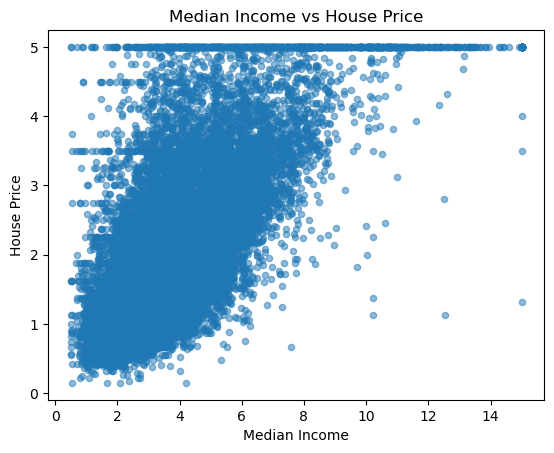

In [63]:
# Basic data visualization
plt.figure(figsize=(4, 3))
df.plot(x='MedInc', y='Price', kind='scatter', alpha=0.5)
plt.title('Median Income vs House Price')
plt.xlabel('Median Income')
plt.ylabel('House Price')
plt.show()

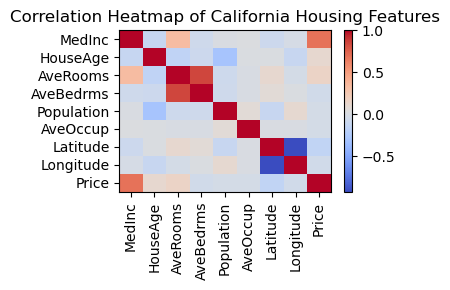

In [64]:
# Correlation heatmap (excluding categorical column)
plt.figure(figsize=(4, 3))
correlation_matrix = df.drop('PriceCategory', axis=1).corr()
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Heatmap of California Housing Features')
plt.tight_layout()
plt.show()

In [65]:
# Handling categorical data
print("\nCount of houses in each price category:")
print(df['PriceCategory'].value_counts())


Count of houses in each price category:
PriceCategory
Medium       9279
Low          5579
High         3699
Very High    2083
Name: count, dtype: int64


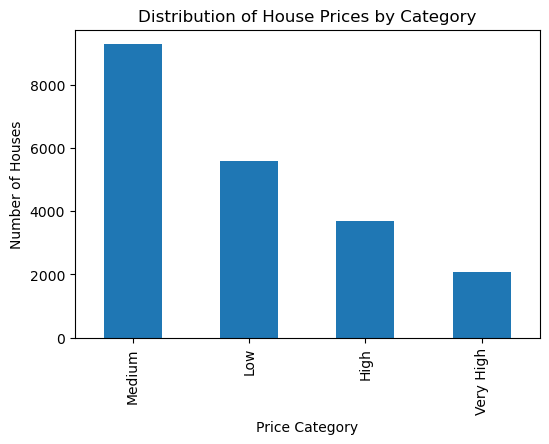

In [66]:
# Visualizing categorical data
plt.figure(figsize=(6, 4))
df['PriceCategory'].value_counts().plot(kind='bar')
plt.title('Distribution of House Prices by Category')
plt.xlabel('Price Category')
plt.ylabel('Number of Houses')
plt.show()

## 4. Introduction to ML Concepts

Time to dive into some of the core concepts of machine learning! We'll start with a high-level overview of different types of machine learning, then move on to some common machine learning algorithms.

### 4.1 Types of Machine Learning
- Supervised Learning: Learning from labeled data
  - Examples: classification, regression
- Unsupervised Learning: Finding patterns in unlabeled data
  - Examples: clustering, dimensionality reduction
- Reinforcement Learning: Learning through interaction with an environment
  - Examples: game playing, robotics

#### 4.2 Common ML Algorithms

##### 4.2.1 Supervised Learning Algorithms

**Supervised learning:** learning a function which approximates the relationship between an input and output from a set of labeled training examples.

E.g.:

![Home price data](img/hp.png)

Our *target* (or dependent variable, or output) is the variable we would like to predict/estimate.

Our *features* (or regressors, or independent variables, or inputs, or covariates) are the variables we can use to make our prediction/estimate.

In this case, $\mathrm{Home \$}\approx f(\mathrm{Sq. ft., \#bed, \#bath,}\ldots)$

##### Regression vs. Classification
In the case of **regression**, we estimate a *quantity*.

![regression](img/reg.png)

In the case of **classification**, we predict a *label* (i.e. a category).

![classification](img/class.png)

##### Linear Regression

Linear regression assumes that $f$ is just a weighted sum of the variables in the covariate matrix $X$:
$$f(X)=\beta_0 + \beta_1x_1 + \beta_2x_2 + \ldots + \beta_px_p + \epsilon$$
Which we can express as just $f(X)=X\mathbf{\beta}$ (and so $Y=X\mathbf{\beta}+\epsilon$).
Turns out the best estimate of $\beta$ is just $(X^TX)^{-1}X^TY$. This is called the Ordinary Least Squares (OLS) estimate. However, that expression sometimes cannot be calculated, and is not computationally efficient to use with large data.

In order to apply OLS regression, our problem should obey certain assumptions.
1. The linear model is correct.
2. The error term ε has mean 0.
3. The regressors (the $x$ terms) are linearly independent.
4. The errors are homoscedastic and uncorrelated.
5. The errors are normally distributed.



In [67]:
# Simple linear regression example
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Generate some random data - in a real problem, we would not know the true relationship described here.
X = np.random.uniform(-4, 4, (100, 1))
y = X**2 + np.random.normal(0, 3, X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
print(f"R-squared score: {model.score(X_test, y_test)}")

R-squared score: 0.03210281524944181


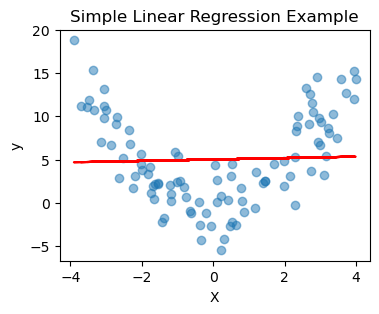

In [68]:
# Plotting the data and the regression line
plt.figure(figsize=(4, 3))
plt.scatter(X, y, alpha=0.5)
plt.plot(X, model.predict(X), color='red')
plt.title('Simple Linear Regression Example')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

Notice a couple of things. One, our fit is abysmal.
Two, there *does* nonetheless seem (visually) to be an interesting relationship between the variables. Maybe $y$ is related not directly to $x$, but to some function of $x$.

In this case, we can get ideas from visualizing the data, but in most cases, a deep understanding of the data will be necessary to make a good model. E.g., suppose in this case we know that $X$ is wind speed, and $y$ is power generated by a wind turbine. An engineer might tell us that in practice $y$ is typically related to the *square* of $X$, rather than $X$ itself. 

R-squared score (X^2 model): 0.6938273410171902


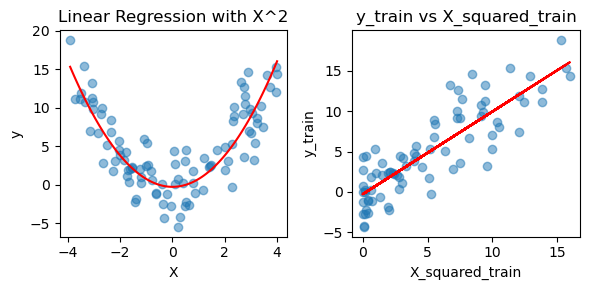

In [69]:
# Fit a linear model where y is regressed on X^2
X_squared_train = X_train**2
X_squared_test = X_test**2

model_squared = LinearRegression()
model_squared.fit(X_squared_train, y_train)

print(f"R-squared score (X^2 model): {model_squared.score(X_squared_test, y_test)}")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plotting the data and the regression curve
axes[0].scatter(X, y, alpha=0.5)
X_curve = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = model_squared.predict(X_curve**2)
axes[0].plot(X_curve, y_pred, color='red')
axes[0].set_title('Linear Regression with X^2')
axes[0].set_xlabel('X')
axes[0].set_ylabel('y')

# Plotting y_train vs X_squared_train
axes[1].scatter(X_squared_train, y_train, alpha=0.5)
axes[1].plot(X_squared_train, model_squared.predict(X_squared_train), color='red')
axes[1].set_title('y_train vs X_squared_train')
axes[1].set_xlabel('X_squared_train')
axes[1].set_ylabel('y_train')

plt.tight_layout()
plt.show()

"Linear" regression is surprisingly flexible!

##### Logistic Regression

Despite its name, logistic regression is a powerful algorithm for *classification*. In a binary classification problem, our target can be thought of as being either 1 or 0. It is possible (but not advisable!) to use a regression algorithm, like linear regression, in such a case.

Suppose that I have data where the target is a binary indicator for whether a student passed a certain class. The data is the student's score on a that class's first exam. 

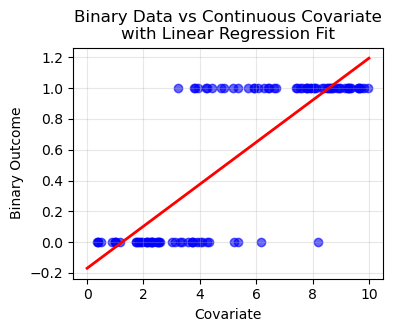

Linear Regression Coefficient: 0.1363
Linear Regression Intercept: -0.1691


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Generate continuous covariate
n_samples = 100
covariate = np.random.uniform(0, 10, n_samples)

# Generate binary data correlated with covariate
probabilities = 1 / (1 + np.exp(-(covariate - 5)))
binary_data = np.random.binomial(1, probabilities)

# Fit linear regression
model = LinearRegression()
model.fit(covariate.reshape(-1, 1), binary_data)

# Create plot
plt.figure(figsize=(4, 3))
plt.scatter(covariate, binary_data, color='blue', alpha=0.6)

# Plot linear regression line
x_plot = np.linspace(0, 10, 100)
y_plot = model.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, y_plot, color='red', lw=2)

plt.xlabel('Covariate')
plt.ylabel('Binary Outcome')
plt.title('Binary Data vs Continuous Covariate\nwith Linear Regression Fit')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Linear Regression Coefficient: {model.coef_[0]:.4f}")
print(f"Linear Regression Intercept: {model.intercept_:.4f}")

The idea of logistic regression is that instead of directly modeling the target, we instead model the *probability* that the target is 1 or 0. This is a specific type of *generalized linear model*, in which the target is transformed by a *link function*. In this case, the link function is the *logit* function, which is the inverse of the *logistic* function. The logistic function is defined as: $$\mathrm{logit}(p)=\log\left(\frac{p}{1-p}\right)$$

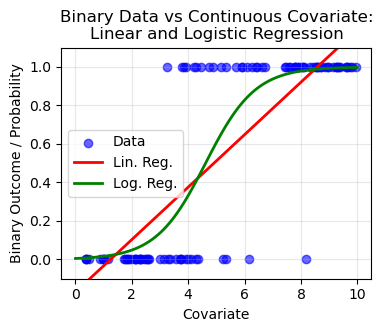

Linear Regression:
Coefficient: 0.1363
Intercept: -0.1691

Logistic Regression:
Coefficient: 1.1350
Intercept: -5.2383


In [72]:
from sklearn.linear_model import LogisticRegression

# Fit logistic regression
logistic_model = LogisticRegression()
logistic_model.fit(covariate.reshape(-1, 1), binary_data)

# Create plot
plt.figure(figsize=(4, 3))
plt.scatter(covariate, binary_data, color='blue', alpha=0.6, label='Data')

# Plot linear regression line
x_plot = np.linspace(0, 10, 100)
y_linear = model.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, y_linear, color='red', lw=2, label='Lin. Reg.')

# Plot logistic regression curve
y_logistic = logistic_model.predict_proba(x_plot.reshape(-1, 1))[:, 1]
plt.plot(x_plot, y_logistic, color='green', lw=2, label='Log. Reg.')

plt.xlabel('Covariate')
plt.ylabel('Binary Outcome / Probability')
plt.title('Binary Data vs Continuous Covariate:\nLinear and Logistic Regression')
plt.legend(loc='center left')
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 1.1)  # Set y-axis limits for better visualization
plt.show()

print("Linear Regression:")
print(f"Coefficient: {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print("\nLogistic Regression:")
print(f"Coefficient: {logistic_model.coef_[0][0]:.4f}")
print(f"Intercept: {logistic_model.intercept_[0]:.4f}")

#### Decision Trees

A totally different approach to modeling data is to use a decision tree. A decision tree is a tree-like model of the dataset. It is a simple model that is easy to interpret and understand. It is also a non-parametric model, which means that it makes no assumptions about the shape of the data - sometimes a big advantage!

In [74]:
# First, let's make some data.

from sklearn.tree import DecisionTreeClassifier, plot_tree

# Create a sample dataset
np.random.seed(42)
n_samples = 1000

data = pd.DataFrame({
    'income': np.random.randint(20000, 200000, n_samples),
    'credit_score': np.random.randint(300, 850, n_samples),
    'debt_to_income': np.random.uniform(0, 0.6, n_samples),
    'employment_length': np.random.randint(0, 30, n_samples),
    'loan_amount': np.random.randint(5000, 100000, n_samples)
})

# Create a rule-based target variable
data['loan_approved'] = (
    (data['credit_score'] > 700) & 
    (data['debt_to_income'] < 0.4) & 
    (data['income'] > 50000)
).astype(int)

# Prepare features and target
X = data[['income', 'credit_score', 'debt_to_income', 'employment_length', 'loan_amount']]
y = data['loan_approved']

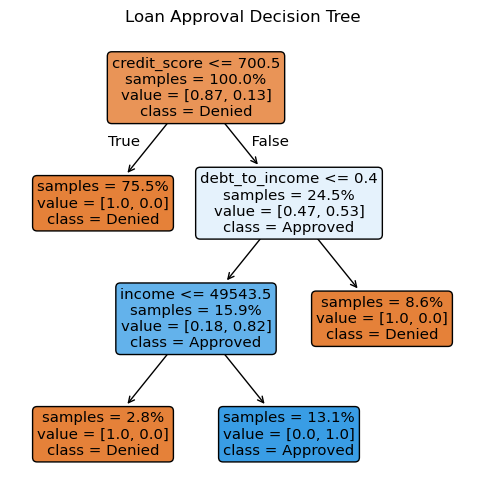

Decision Tree created and visualized based on the loan approval data.


In [75]:
# Create and train the Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X, y)

# Visualize the decision tree
plt.figure(figsize=(6, 6))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=['Denied', 'Approved'], rounded=True, impurity=False, proportion=True, precision=2)
plt.title("Loan Approval Decision Tree")
plt.show()

print("Decision Tree created and visualized based on the loan approval data.")

#### Random Forests

The decision tree is highly interpretable, which is sometimes a big advantage. But, it is a weak machine learning algorithm; not nearly as powerful as some others. One way to make it more powerful is to use a *random forest*. A random forest is an ensemble of decision trees, which means that it is a collection of decision trees that are trained separately and then combined to make a prediction. Essentially, a random forest is a collection of decision trees that are trained separately and then combined (by averaging or voting) to make a prediction. They can be used for both classification and regression tasks.

You lose the interpretability of a single decision tree, but you gain a lot of predictive power. And random forests are very easy to use and very flexible, don't require much tuning, are very hard to overfit, and don't make many assumptions about the data. A good general-purpose algorithm.

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

# Create and train the Random Forest
rf = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=42)
rf.fit(X, y)

RandomForestClassifier(max_depth=2, n_estimators=10, random_state=42)

Random Forests makes it easy to see which features are most important in making a prediction. This is because the algorithm can keep track of how much each feature contributes to the trees in the forest.

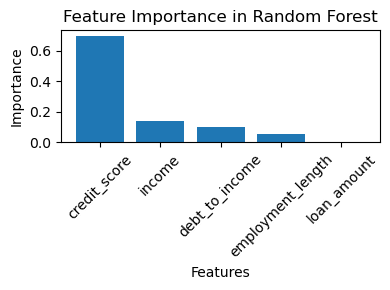

In [77]:
# Visualize feature importances
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(4, 3))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title("Feature Importance in Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

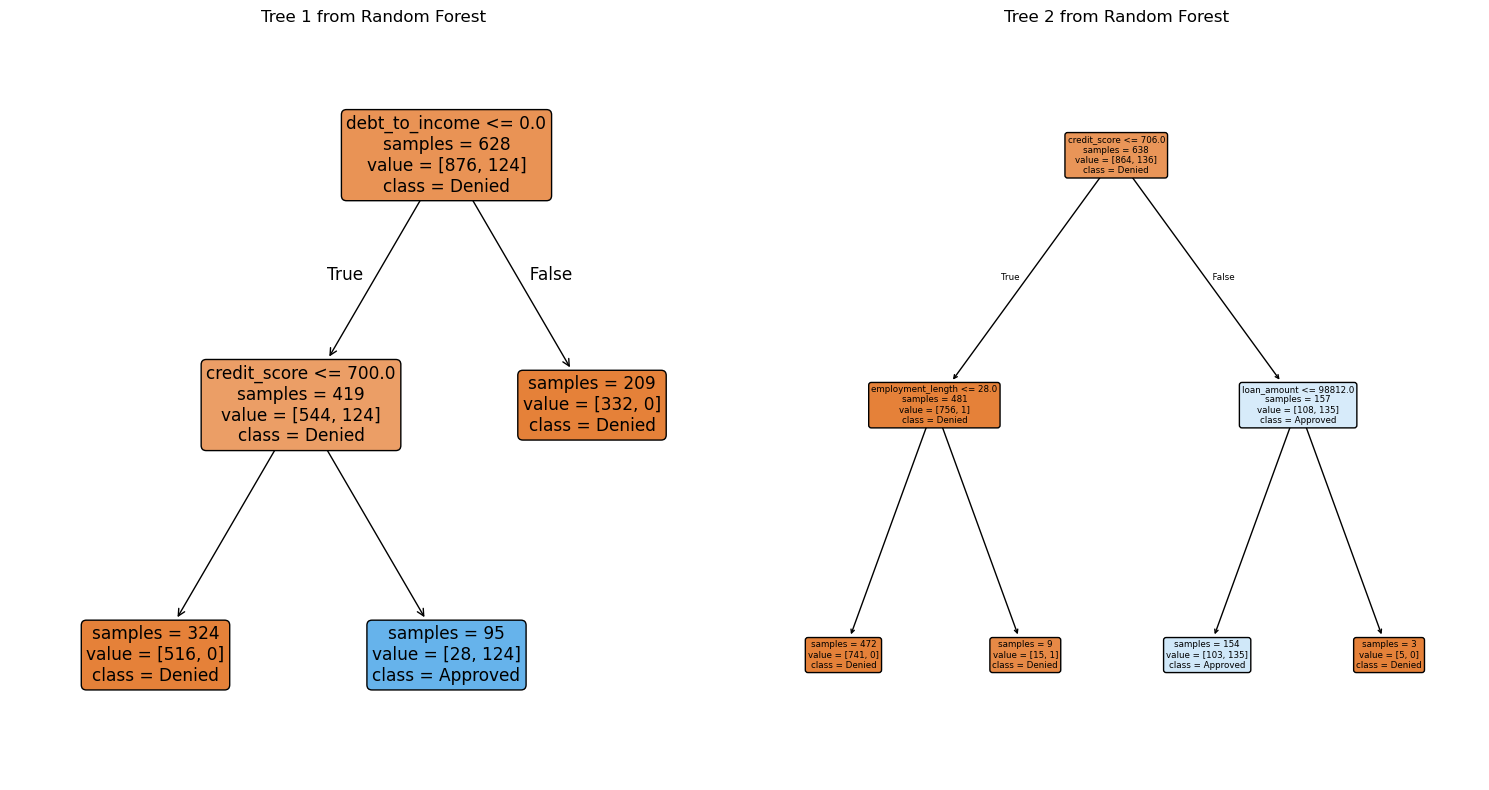

In [78]:
# Plot two trees side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# First tree
plot_tree(rf.estimators_[0], 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Denied', 'Approved'], 
          rounded=True,
          impurity=False,
          proportion=False,
          node_ids=False,
          precision=0,
          ax=axes[0])
axes[0].set_title("Tree 1 from Random Forest")

# Second tree
plot_tree(rf.estimators_[1], 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Denied', 'Approved'], 
          rounded=True,
          impurity=False,
          proportion=False,
          node_ids=False,
          precision=0,
          ax=axes[1])
axes[1].set_title("Tree 2 from Random Forest")

plt.tight_layout()
plt.show()




##### Support Vector Machines

Support Vector Machines (SVMs) are a powerful supervised learning algorithm used for classification or regression tasks. They are based on the idea of finding the hyperplane that best divides a dataset into two classes. The hyperplane is the line that best separates the two classes. The SVM algorithm finds the hyperplane that maximizes the margin between the two classes.

![hyperplanes](img/svm_hp.png)

In cases where the data cannot be linearly separated, SVMs can use a *kernel trick* to transform the data into a higher-dimensional space where it can be separated. This is a very powerful technique that allows SVMs to work well on a wide variety of datasets.

![kernel](img/svm_hd.png)

In [ ]:
# First, let's prepare some data.

from sklearn import datasets, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Load the iris dataset
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]  # We'll use petal length and width
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Now, let's train a Support Vector Machine (SVM) classifier.

# Train SVM classifier
svm_classifier = svm.SVC(kernel='rbf', random_state=42)
svm_classifier.fit(X_train_scaled, y_train)

In [ ]:
# Now, let's make predictions and evaluate the model.

# Make predictions
y_pred = svm_classifier.predict(X_test_scaled)

# Print the accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

# Visualize the decision boundaries
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = plt.cm.RdYlBu

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx / len(np.unique(y))),
                    marker=markers[idx], label=iris.target_names[cl])

    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='none', alpha=1.0, linewidth=1, marker='o', 
                    s=55, edgecolors='black', label='test set')

# Visualize the results
X_combined = np.vstack((X_train_scaled, X_test_scaled))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, classifier=svm_classifier, test_idx=range(len(y_train), len(y_combined)))

plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.title('SVM Decision Regions - Iris Dataset')
plt.tight_layout()
plt.show()

##### K-Nearest Neighbors

K-Nearest Neighbors (KNN) is a simple, easy-to-understand algorithm that can be used for both classification and regression tasks. It is a non-parametric algorithm, which means that it makes no assumptions about the shape of the data. The basic idea behind KNN is that similar data points are close to each other in the feature space. To make a prediction, KNN looks at the K-nearest neighbors of a data point and takes a majority vote (for classification) or an average (for regression) to make a prediction.

In [ ]:
from sklearn import neighbors

# Train KNN classifier on the iris data
k = 5  # number of neighbors
knn_classifier = neighbors.KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_scaled, y_train)

In [ ]:
# Make predictions
y_pred = knn_classifier.predict(X_test_scaled)

# Print the accuracy and classification report
print(f"KNN (k={k}) Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

# Visualize the decision boundaries
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = plt.cm.RdYlBu

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx / len(np.unique(y))),
                    marker=markers[idx], label=iris.target_names[cl])

    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='none', alpha=1.0, linewidth=1, marker='o', 
                    s=55, edgecolors='black', label='test set')

# Visualize the results
X_combined = np.vstack((X_train_scaled, X_test_scaled))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, classifier=knn_classifier, test_idx=range(len(y_train), len(y_combined)))

plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.title(f'KNN (k={k}) Decision Regions - Iris Dataset')
plt.tight_layout()
plt.show()

#### 4.2.2 Unsupervised Learning Algorithms

**Unsupervised learning:** finding patterns in data without any labels.

![unsupervised](img/kmc.png)

Common types of unsupervised learning algorithms include:
* Clustering: grouping similar data points together
* Dimensionality reduction: reducing the number of features in a dataset
* Anomaly detection: finding outliers in a dataset

##### Clustering

Clustering is a common way to discover patterns and subgroups that are interesting in our data. For example, we might want to group customers into segments based on their purchasing behavior, or group documents based on their content. There are many different clustering algorithms. See just a few of those implemented in Scikit-Learn:

<img src="img/skl_cl.png" alt="clustering" width="85%" />

##### K-Means Clustering

K-Means is a simple and popular clustering algorithm that is used to partition a dataset into K clusters. The algorithm works by iteratively assigning data points to clusters based on the distance between the data point and the cluster center. The cluster center is then updated to be the mean of all the data points assigned to that cluster. This process is repeated until the algorithm converges.

We can look at this in action using the Iris dataset, which is a dataset containing information about iris flowers. The dataset contains 150 samples and 4 features. The goal is to cluster the flowers into different groups based on their features. Though we actually know the flower species, for this example we imagine that we don't -- we just have the features, and we want to see if we can group the flowers into clusters.

Silhouette Score: 0.6741313115143868
Calinski-Harabasz Index: 1149.6677889350308

Comparison with true labels:
Adjusted Rand Index: 0.8856970310281228
Normalized Mutual Information: 0.8641855068202219


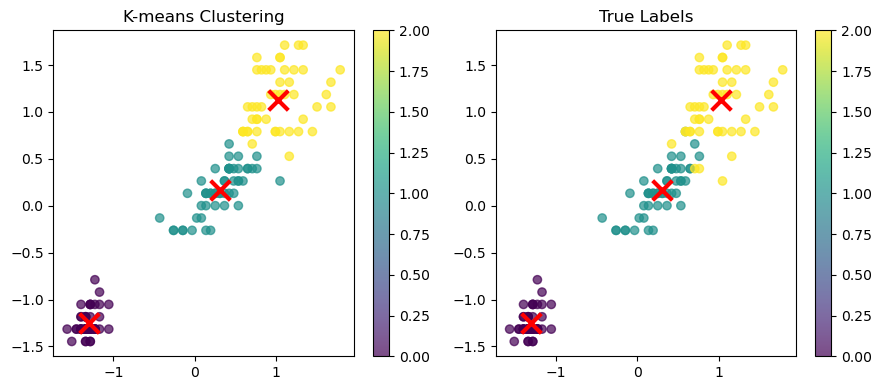

In [79]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score

# Load the iris dataset
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]  # We'll use petal length and width

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

# Evaluate the clustering
print("Silhouette Score:", silhouette_score(X_scaled, y_kmeans))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled, y_kmeans))

# Compare with true labels
print("\nComparison with true labels:")
print("Adjusted Rand Index:", adjusted_rand_score(iris.target, y_kmeans))
print("Normalized Mutual Information:", normalized_mutual_info_score(iris.target, y_kmeans))

# Define the centroids of the clusters
centroids = kmeans.cluster_centers_

# Create a mapping function. This is only here to make the plots consistent in color.
def map_labels(y_kmeans, y_true):
    mapping = {}
    for k in range(n_clusters):
        k_indices = y_kmeans == k
        k_true = y_true[k_indices]
        mapping[k] = np.bincount(k_true).argmax()
    return np.array([mapping[k] for k in y_kmeans])

# Apply the mapping
y_kmeans_mapped = map_labels(y_kmeans, iris.target)

# Plot comparison with true labels
plt.figure(figsize=(9, 4))

plt.subplot(121)
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_kmeans_mapped, cmap='viridis', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, linewidths=3)
plt.title('K-means Clustering')
plt.colorbar(scatter)

plt.subplot(122)
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=iris.target, cmap='viridis', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, linewidths=3)
plt.title('True Labels')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

Now let's see K-Means in action on a more complex dataset. We'll use the Labeled Faces in the Wild dataset, which is a dataset containing images of faces. The dataset contains 13,233 sample images. We'll use K-Means to cluster the faces into different groups based on their features.

In [80]:
from sklearn.datasets import fetch_lfw_people
from sklearn import cluster, decomposition

lfw_people = fetch_lfw_people()
lfw_people.data.shape
n_samples, n_features = lfw_people.data.shape

# Global centering (focus on one feature, centering all samples)
faces_centered = lfw_people.data - lfw_people.data.mean(axis=0)

# Local centering (focus on one sample, centering all features)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 13233 faces


In [81]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (62, 47)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

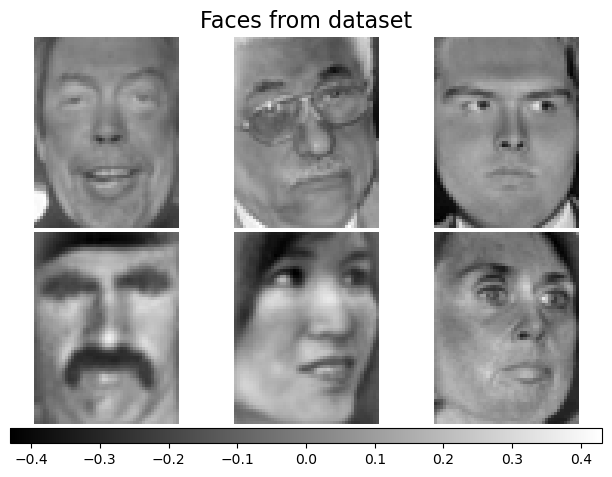

In [82]:
plot_gallery("Faces from dataset", faces_centered[:n_components])

Now let's apply K-Means to the faces dataset. We can then examine the cluster centroids. This centroid will be like the "average" face in the cluster, for each of our clusters. 

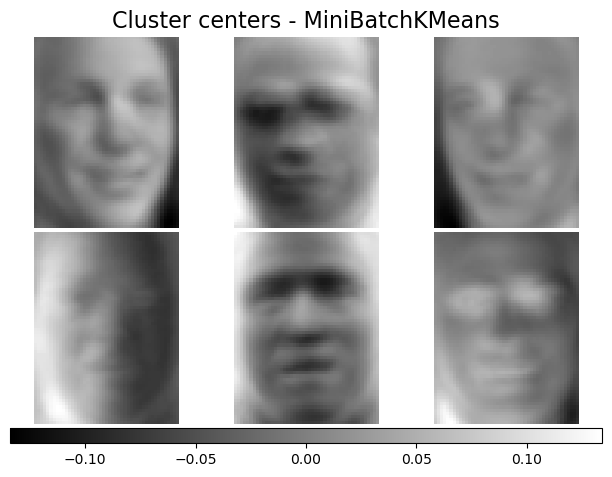

In [83]:
kmeans_estimator = cluster.MiniBatchKMeans(
    n_clusters=24,
    tol=1e-3,
    batch_size=1000,
    max_iter=1000,
    random_state=355,
)
kmeans_estimator.fit(faces_centered)
plot_gallery(
    "Cluster centers - MiniBatchKMeans",
    kmeans_estimator.cluster_centers_[:n_components],
)

#### Dimensionality Reduction

Dimensionality reduction is the process of reducing the number of features in a dataset. This can be useful for a number of reasons, including:
* Reducing the computational cost of working with high-dimensional data
* Reducing the noise in the data
* Visualizing high-dimensional data in a lower-dimensional space

Principal Component Analysis (PCA) is a popular dimensionality reduction technique often used for the first two reasons above. It works by finding the directions (or principal components) in which the data varies the most. These directions are then used to transform the data into a lower-dimensional space. PCA is often used before applying other machine learning algorithms to the data, including supervised learning algorithms.

Why is PCA used this way? Imagine you could construct your ideal ML data set for some phenomenon you’re studying. Three things you’d want:
* High variance features that are
* Uncorrelated, and are also
* Few in number.

PCA makes your data more aligned with these three goals. It replaces your original features with new ones that are uncorrelated and ordered by how much variance they explain. So you can keep only the few features that explain most of the variance, and throw away the rest. PCA is implicitly lossy compression.

![pca](img/pca.png)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming faces_centered is already defined as per your previous code

# Perform PCA on the entire dataset
pca = PCA().fit(faces_centered)

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Define the variance levels we want to visualize
variance_levels = [0.5, 0.75, 0.9, 0.95, 0.99, 1.0]

# Find the number of components needed for each variance level
n_components_list = [np.argmax(cumulative_variance_ratio >= level) + 1 for level in variance_levels]

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

# Function to reconstruct and plot a face
def plot_face(ax, face, n_components, variance):
    if n_components == 1:
        n_components = face.shape[0]
    pca_partial = PCA(n_components=n_components)
    face_pca = pca_partial.fit_transform(faces_centered)
    face_approximation = pca_partial.inverse_transform(pca_partial.transform(face.reshape(1, -1)))
    ax.imshow(face_approximation.reshape(lfw_people.images[0].shape), cmap='gray')
    ax.set_title(f'{variance:.0%} variance\n({n_components} components)')
    ax.axis('off')

# Choose a random face
random_face_index = np.random.randint(faces_centered.shape[0])
face = faces_centered[random_face_index]

# Plot the face at different variance levels
for ax, n_components, variance in zip(axes, n_components_list, variance_levels):
    plot_face(ax, face, n_components, variance)

plt.tight_layout()
plt.show()

# Print out the number of components for each variance level
for variance, n_components in zip(variance_levels, n_components_list):
    print(f"{variance:.0%} variance explained by {n_components} components")

# Print the total number of samples and features
print(f"\nDataset consists of {faces_centered.shape[0]} faces")
print(f"Each face has {faces_centered.shape[1]} features")

#### T-SNE

Dimensionality reduction is also used to visualize high-dimensional data in a lower-dimensional space. One popular technique for this is t-distributed Stochastic Neighbor Embedding (t-SNE). It works by modeling the similarity between data points in the high-dimensional space and the low-dimensional space. t-SNE is often used to visualize high-dimensional data in two or three dimensions.

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X, y = mnist.data, mnist.target

# Convert target to integer
y = y.astype(int)

# Take a subset of the data to speed up computation
n_samples = 5000
random_idx = np.random.choice(X.shape[0], n_samples, replace=False)
X_subset = X[random_idx]
y_subset = y[random_idx]

# Normalize the data
X_normalized = X_subset / 255.0

# Apply t-SNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, n_iter=1000, learning_rate='auto', init='pca')
X_tsne = tsne.fit_transform(X_normalized)

# Create a color map
num_classes = len(np.unique(y))
colors = plt.cm.jet(np.linspace(0, 1, num_classes))
cmap = ListedColormap(colors)

# Plot the t-SNE results
plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap=cmap, alpha=0.7, s=5)
plt.colorbar(scatter)
plt.title("t-SNE visualization of MNIST dataset")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Digit {i}', 
                   markerfacecolor=colors[i], markersize=10) for i in range(num_classes)]
plt.legend(handles=legend_elements, loc='best', title="Digits")

plt.tight_layout()
plt.show()

# Function to plot some example digits
def plot_example_digits(X, y, num_examples=10):
    plt.figure(figsize=(15, 3))
    for i in range(num_examples):
        ax = plt.subplot(1, num_examples, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray_r')
        plt.title(f"Digit: {y[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot example digits
plot_example_digits(X_subset, y_subset)

print("t-SNE visualization complete!")

### 4.3 Model Evaluation Metrics

#### 4.3.1 Supervised Learning Metrics

How do we evaluate the performance of a machine learning model? There are many different metrics that can be used, depending on the type of problem and the goals of the model. The choice of metric will almost always depend heavily on the type of problem you are trying to solve.

But how do we apply these metrics? We can split our data into a training set and a test set. We train our model on the training set and then evaluate its performance on the test set. If we're tuning hyperparameters, we might use a validation set as well.

![train_test](img/tr_ts.png)

Even better than a single train/test split is to use *cross-validation*. In cross-validation, the data is split into K folds, and the model is trained and evaluated K times, each time using a different fold as the test set. This gives us a more robust estimate of the model's performance.

![cross_val](img/cvl.png)

##### Regression Metrics

In a regression problem, we are trying to predict a continuous value. Some common metrics for evaluating regression models include:
* Mean Squared Error (MSE) - the average of the squared differences between the predicted and actual values
* Root Mean Squared Error (RMSE) - the square root of the MSE. More interpretable than MSE due to being in the same units as the target variable
* Mean Absolute Error (MAE) - the average of the absolute differences between the predicted and actual values
* R-squared (R2) - a measure of how well the model fits the data



In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load the California Housing dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display metrics
print("Regression Metrics for California Housing Dataset:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Display feature names and their coefficients
feature_names = housing.feature_names
coefficients = model.coef_

print("\nFeature Coefficients:")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.4f}")

##### Classification Metrics

In a classification problem, we are trying to predict a label. Some common metrics for evaluating classification models include:
* Accuracy - the proportion of correctly classified instances
* Precision - the proportion of true positive predictions among all positive predictions
* Recall - the proportion of true positive predictions among all actual positive instances
* F1 Score - the harmonic mean of precision and recall
* ROC AUC - the area under the Receiver Operating Characteristic curve

<img src="img/prec_rec.png" alt="precision_recall" style="width:40%">

Note that all of the above *except* for ROC AUC depend on your choice of threshold for classification. ROC AUC is a metric that is threshold-independent, and is often used when you want to compare models across different thresholds.

Let's look at this in action, after fitting a logistic regression model on the UCI Ionosphere dataset. In this dataset, we are trying to predict whether a radar return is "good" or "bad" based on features such as the signal's amplitude and frequency.

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Load the Ionosphere dataset
ionosphere = fetch_openml(name="ionosphere", version=1, as_frame=True)
X, y = ionosphere.data, ionosphere.target
y = (y == 'g').astype(int)  # Convert to binary (good=1, bad=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit a logistic regression model with reduced performance
model = LogisticRegression(random_state=42, C=0.01, max_iter=1000) 
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Display metrics
print("Classification Metrics for Ionosphere Dataset:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Display feature importances
feature_importance = abs(model.coef_[0])
feature_names = X.columns

print("\nTop 5 Most Important Features:")
sorted_idx = np.argsort(feature_importance)
for idx in sorted_idx[-5:]:
    print(f"{feature_names[idx]}: {feature_importance[idx]:.4f}")

##### Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model. It shows the number of true positives, false positives, true negatives, and false negatives. From the confusion matrix, we can calculate many different metrics, including accuracy, precision, recall, and F1 score.

In [ ]:
# Display the confusion matrix as a plot
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

